In [1]:
#!pip install torch=='1.9.0'
#!pip install torch-scatter torch-sparse torch-cluster torch-spline-conv torch-geometric -f https://data.pyg.org/whl/torch-1.9.0+cu102.html

## Cora citation network

To demonstrate, we make use of the `Cora` dataset, which is a **citation network** where nodes represent documents.
Each node is described by a 1433-dimensional bag-of-words feature vector.
Two documents are connected if there exists a citation link between them.  
The task are:
- Node classification: to infer the category of each document (7 in total).
- Link prediction: to predict missing citations between documents.

This dataset was first introduced by [Yang et al. (2016)](https://arxiv.org/abs/1603.08861) as one of the datasets of the `Planetoid` benchmark suite.

In [2]:
import numpy as np

import torch
from torch_geometric.datasets import Planetoid

dataset = Planetoid(root='data/Planetoid', name='Cora')

print()
print(f'Dataset: {dataset}:')
print('======================')
print(f'Number of graphs: {len(dataset)}')
print(f'Number of features: {dataset.num_features}')
print(f'Number of classes: {dataset.num_classes}')

data = dataset[0]  # Get the first graph object


Dataset: Cora():
Number of graphs: 1
Number of features: 1433
Number of classes: 7


In [3]:
data

Data(x=[2708, 1433], edge_index=[2, 10556], y=[2708], train_mask=[2708], val_mask=[2708], test_mask=[2708])

In [4]:
# x : node feature matrix [#num_nodes, #num_features] 
# edge_index :  [#nodes_in_edge, #num_edges] e.g [[1,2],[3,4]] => (1,3), (2,4) in E
# y : labels
# train_mask, val_mask, test_mask : bit mask1

Data fields are not fixed, you can add/delete fields

In [5]:
data.z = torch.Tensor(np.array([0 for i in range(len(data.x))]))
data

Data(x=[2708, 1433], edge_index=[2, 10556], y=[2708], train_mask=[2708], val_mask=[2708], test_mask=[2708], z=[2708])

In [6]:
del(data.z)

In [7]:
data

Data(x=[2708, 1433], edge_index=[2, 10556], y=[2708], train_mask=[2708], val_mask=[2708], test_mask=[2708])

We delete masks to perform custom nodes split

In [8]:
del(data.train_mask)
del(data.val_mask)
del(data.test_mask)

In [9]:
# 1 - Normalize features

from torch_geometric.transforms import NormalizeFeatures

transform = NormalizeFeatures() #Row-normalizes the attributes to sum-up to one
data = transform(data)

In [10]:
# 2 - Random Node Split

from torch_geometric.transforms import RandomNodeSplit

split = RandomNodeSplit(num_val=0.0,num_test=0.30)
data = split(data)

In [11]:
print(data)
print(f'Training set rate: {int(data.train_mask.sum()) / data.num_nodes:.2f}')
print(f'Validation set rate: {int(data.val_mask.sum()) / data.num_nodes:.2f}')
print(f'Test set rate: {int(data.test_mask.sum()) / data.num_nodes:.2f}')

Data(x=[2708, 1433], edge_index=[2, 10556], y=[2708], train_mask=[2708], val_mask=[2708], test_mask=[2708])
Training set rate: 0.70
Validation set rate: 0.00
Test set rate: 0.30


## Load your own dataset

Many options...  
My favourite is use `from\_networkx` util 

In [12]:
import networkx as nx

mouse = nx.read_edgelist('bn-mouse-kasthuri_graph_v4.edges')

In [13]:
#Do everything you can on networkx (add attributes, compute features, remove self-loops / isolated nodes, ...)

#Example: add degree as node feature
deg = dict(mouse.degree())
nx.set_node_attributes(mouse,deg,'degree')

In [14]:
from torch_geometric.utils import from_networkx

mouse_data = from_networkx(mouse, group_node_attrs = all)

In [15]:
mouse_data

Data(edge_index=[2, 3118], x=[1029, 1])

#### No feature? No problem! Constant encoder

In [16]:
from torch_geometric.transforms import Constant

constant = Constant(cat=False) #cat = False drop the other features
mouse_data = constant(mouse_data)

In [17]:
mouse_data.x

tensor([[1.],
        [1.],
        [1.],
        ...,
        [1.],
        [1.],
        [1.]])

#### Create your own dataset in PyG: https://pytorch-geometric.readthedocs.io/en/latest/modules/data.html#torch_geometric.data.Data

## GNN Model

In [18]:
from torch_geometric.nn import GCNConv, Linear
import torch.nn.functional as F

In [19]:
class CoraGCN(torch.nn.Module):
    
    def __init__(self):
        super().__init__()
        torch.manual_seed(1234567) #manual seed for reproducibility
        
        self.lin1 = Linear(dataset.num_features, 64) 
        self.lin2 = Linear(64, 32) #two MLP layers to preprocess the BoW
        self.conv1 = GCNConv(32, 16) 
        self.conv2 = GCNConv(16, dataset.num_classes) #two GCNConv to compute embeddings
        
    def reset_parameters(self):
        self.lin1.reset_parameters()
        self.lin2.reset_parameters()
        self.conv1.reset_parameters()
        self.conv2.reset_parameters()

    def forward(self, x, edge_index):
        #x : node feature matrix, edge_index : structure of the graph
        x = self.lin1(x)
        x = x.relu()
        x = F.dropout(x, p=0.25, training=self.training)
        
        x = self.lin2(x)
        x = x.relu()
        x = F.dropout(x, p=0.25, training=self.training)
        
        x = self.conv1(x, edge_index)
        x = x.relu()
        x = F.dropout(x, p=0.25, training=self.training)
        
        x = self.conv2(x, edge_index)
        
        return x

### Training

In [20]:
model = CoraGCN()
model.reset_parameters()

In [21]:
model

CoraGCN(
  (lin1): Linear(1433, 64, bias=True)
  (lin2): Linear(64, 32, bias=True)
  (conv1): GCNConv(32, 16)
  (conv2): GCNConv(16, 7)
)

<img src="CoraGCN.png" alt="nodepred_gcn" width="500"/>

In [22]:
optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4) #SGD, Adagrad
criterion = torch.nn.CrossEntropyLoss()

def train():
    model.train()
    optimizer.zero_grad()  # Clear gradients.
    out = model(data.x, data.edge_index)  # Perform a single forward pass.
    loss = criterion(out[data.train_mask], data.y[data.train_mask])  # Compute the loss solely based on the training nodes.
    loss.backward()  # Derive gradients.
    optimizer.step()  # Update parameters based on gradients.
    return loss

def test():
    model.eval()
    out = model(data.x, data.edge_index)
    
    ### NODE CLASSIFICATION ACTS HERE ###
    pred = out.argmax(dim=1)  # Use the class with highest probability.
    ### --- ###
    
    # Evaluation
    train_correct = pred[data.train_mask] == data.y[data.train_mask]  # Check against ground-truth labels for train set.
    train_acc = int(train_correct.sum()) / int(data.train_mask.sum())  # Derive ratio of correct predictions for train set.
    test_correct = pred[data.test_mask] == data.y[data.test_mask]  # Check against ground-truth labels for test set.
    test_acc = int(test_correct.sum()) / int(data.test_mask.sum())  # Derive ratio of correct predictions for test set.
    return train_acc, test_acc


for epoch in range(1, 101):
    loss = train()
    print(f'Epoch: {epoch:03d}, Loss: {loss:.4f}')

Epoch: 001, Loss: 1.9420
Epoch: 002, Loss: 1.9295
Epoch: 003, Loss: 1.9190
Epoch: 004, Loss: 1.9057
Epoch: 005, Loss: 1.8897
Epoch: 006, Loss: 1.8754
Epoch: 007, Loss: 1.8643
Epoch: 008, Loss: 1.8368
Epoch: 009, Loss: 1.8308
Epoch: 010, Loss: 1.8180
Epoch: 011, Loss: 1.8078
Epoch: 012, Loss: 1.8009
Epoch: 013, Loss: 1.7840
Epoch: 014, Loss: 1.7701
Epoch: 015, Loss: 1.7378
Epoch: 016, Loss: 1.7167
Epoch: 017, Loss: 1.6829
Epoch: 018, Loss: 1.6561
Epoch: 019, Loss: 1.6316
Epoch: 020, Loss: 1.5937
Epoch: 021, Loss: 1.5736
Epoch: 022, Loss: 1.5337
Epoch: 023, Loss: 1.5149
Epoch: 024, Loss: 1.4935
Epoch: 025, Loss: 1.4746
Epoch: 026, Loss: 1.4401
Epoch: 027, Loss: 1.4228
Epoch: 028, Loss: 1.4139
Epoch: 029, Loss: 1.3813
Epoch: 030, Loss: 1.3552
Epoch: 031, Loss: 1.3494
Epoch: 032, Loss: 1.3077
Epoch: 033, Loss: 1.2738
Epoch: 034, Loss: 1.2418
Epoch: 035, Loss: 1.2076
Epoch: 036, Loss: 1.1684
Epoch: 037, Loss: 1.1372
Epoch: 038, Loss: 1.0984
Epoch: 039, Loss: 1.0558
Epoch: 040, Loss: 1.0112


In [23]:
train_acc,test_acc = test()
print(f'Train Accuracy: {train_acc:.4f}\nTest Accuracy: {test_acc:.4f}')

Train Accuracy: 0.9415
Test Accuracy: 0.8707


/home/jupyter-manuel_dileo/.local/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/home/jupyter-manuel_dileo/.local/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


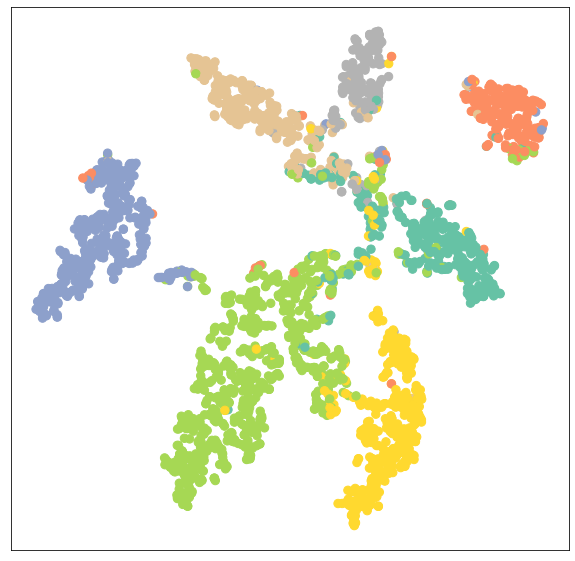

In [24]:
# Helper function for visualization.
%matplotlib inline
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

def visualize(h, color):
    z = TSNE(n_components=2).fit_transform(h.detach().cpu().numpy()) #TSNE applied to node embeddings as numpy arrays

    plt.figure(figsize=(10,10))
    plt.xticks([])
    plt.yticks([])

    plt.scatter(z[:, 0], z[:, 1], s=70, c=color, cmap="Set2")
    plt.show()

model.eval()
out = model(data.x, data.edge_index)
visualize(out, color=data.y)

#### TODO

- Perform hyperparameter optimization
- Print train and test accuracy along the epochs
- Print different evaluation metrics (e.g. confusion matrix)

### Link Prediction

#### Link split and negative sampling

In [25]:
#Perform random link split
from torch_geometric.transforms import RandomLinkSplit

link_split = RandomLinkSplit(num_val=0.0,num_test=0.25)
train_link, val_link, test_link = link_split(data)

In [26]:
train_link

Data(x=[2708, 1433], edge_index=[2, 7917], y=[2708], train_mask=[2708], val_mask=[2708], test_mask=[2708], edge_label=[15834], edge_label_index=[2, 15834])

In [27]:
# edge_label : 1 for closed link, 0 for open link
# edge_label_index: edge_index + negative_sampling edge_index

`RandomLinkSplit` performs split + negative sampling: this is perfect for static networks. Suppose you want to test your model in a future time interval... you do not need to perform a link split. How to perform negative sampling?

In [28]:
from torch_geometric.utils import negative_sampling

future_data = Planetoid(root='data/Planetoid', name='Cora')[0]

#NEGATIVE SAMPLING
future_neg_edge_index = negative_sampling(
        edge_index=future_data.edge_index, #positive edges
        num_nodes=future_data.num_nodes, # number of nodes
        num_neg_samples=future_data.edge_index.size(1)) # number of neg_sample equal to number of pos_edges

In [29]:
future_neg_edge_index

tensor([[1274,  661,  411,  ..., 2404, 2475, 2559],
        [ 336,   89,  275,  ..., 1148, 2461, 2067]])

In [30]:
#edge index ok, edge_label concat, edge_label_index concat
num_pos_edge = future_data.edge_index.size(1)
future_data.edge_label = torch.Tensor(np.array([1 for i in range(num_pos_edge)] + [0 for i in range(num_pos_edge)]))
future_data.edge_label_index = torch.cat([future_data.edge_index, future_neg_edge_index], dim=-1)

In [31]:
future_data

Data(x=[2708, 1433], edge_index=[2, 10556], y=[2708], train_mask=[2708], val_mask=[2708], test_mask=[2708], edge_label=[21112], edge_label_index=[2, 21112])

#### GNN Training

In [32]:
from sklearn.metrics import roc_auc_score

We can re-use the same GNN model!

<img src="CoraGCNLinkPre.png" alt="linkpred_gcn" width="500"/>

In [33]:
model = CoraGCN()
model.reset_parameters()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)
criterion =  torch.nn.BCEWithLogitsLoss() #change loss function

def train_linkpre():
    
    model.train()
    optimizer.zero_grad()  # Clear gradients.
    out = model(train_link.x, train_link.edge_index)  # Perform a single forward pass.
    
    ### LINK PREDICTION ACTS HERE ###
    
    out_src = out[train_link.edge_label_index[0]] #embedding src nodes
    out_dst = out[train_link.edge_label_index[1]] #embedding dst nodes
    
    # LINK EMBEDDING #
    # 1 - Dot Product
    out_sim = out_src * out_dst #dotproduct
    pred = torch.sum(out_sim, dim=-1)
    
    # 2 - Concatenation + linear function
    #out_sim = torch.cat([out_src, out_dst], dim=-1)
    #pred = torch.sum(out_sim,dim=-1)
    
    
    loss = criterion(pred, train_link.edge_label.type_as(pred))  # Compute the loss solely based on the training nodes.
    loss.backward()  # Derive gradients.
    optimizer.step()  # Update parameters based on gradients.
    return loss

def test_linkpre(test_link):
    model.eval()
    out = model(test_link.x, test_link.edge_index)
    
    ### LINK PREDICTION ACTS HERE ###
    
    out_src = out[test_link.edge_label_index[0]] #embedding src nodes
    out_dst = out[test_link.edge_label_index[1]] #embedding dst nodes
    
    # LINK EMBEDDING #
    # 1 - Dot Product
    out_sim = out_src * out_dst
    h = torch.sum(out_sim, dim=-1)
    
    # 2 - Concatenation + linear function
    #out_sim = torch.cat([out_src, out_dst], dim=-1)
    #h = torch.sum(out_sim,dim=-1)
    
    pred_cont = torch.sigmoid(h).cpu().detach().numpy()
    
    # EVALUATION
    test_label = test_link.edge_label.cpu().detach().numpy() #retrieve test set labels
    test_roc_score = roc_auc_score(test_label, pred_cont) #comput AUROC score for test set
    
    return test_roc_score


for epoch in range(1, 101):
    loss = train_linkpre()
    print(f'Epoch: {epoch:03d}, Loss: {loss:.4f}')

Epoch: 001, Loss: 0.6903
Epoch: 002, Loss: 0.6842
Epoch: 003, Loss: 0.6778
Epoch: 004, Loss: 0.6834
Epoch: 005, Loss: 0.6767
Epoch: 006, Loss: 0.6772
Epoch: 007, Loss: 0.6783
Epoch: 008, Loss: 0.6774
Epoch: 009, Loss: 0.6767
Epoch: 010, Loss: 0.6746
Epoch: 011, Loss: 0.6753
Epoch: 012, Loss: 0.6738
Epoch: 013, Loss: 0.6749
Epoch: 014, Loss: 0.6737
Epoch: 015, Loss: 0.6723
Epoch: 016, Loss: 0.6722
Epoch: 017, Loss: 0.6722
Epoch: 018, Loss: 0.6710
Epoch: 019, Loss: 0.6698
Epoch: 020, Loss: 0.6704
Epoch: 021, Loss: 0.6688
Epoch: 022, Loss: 0.6681
Epoch: 023, Loss: 0.6698
Epoch: 024, Loss: 0.6677
Epoch: 025, Loss: 0.6655
Epoch: 026, Loss: 0.6659
Epoch: 027, Loss: 0.6663
Epoch: 028, Loss: 0.6641
Epoch: 029, Loss: 0.6633
Epoch: 030, Loss: 0.6622
Epoch: 031, Loss: 0.6595
Epoch: 032, Loss: 0.6581
Epoch: 033, Loss: 0.6584
Epoch: 034, Loss: 0.6601
Epoch: 035, Loss: 0.6561
Epoch: 036, Loss: 0.6552
Epoch: 037, Loss: 0.6526
Epoch: 038, Loss: 0.6511
Epoch: 039, Loss: 0.6459
Epoch: 040, Loss: 0.6435


In [34]:
roc_train = test_linkpre(train_link)
roc_test = test_linkpre(test_link)
print(f'Train AUROC: {roc_train:.4f}\nTest AUROC: {roc_test:.4f}')

Train AUROC: 0.8340
Test AUROC: 0.7796
